In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 7.2MB/s 
     |████████████████████████████████| 9.5MB 13.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense

from keras.optimizers import Adam

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/time_series_covid19_deaths_global.csv')

In [4]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,936,957,971,994,1010,1012,1048,1094,1113,1147,1164,1181,1185,1186,1190,1211,1225,1248,1259,1269,1270,1271,1271,1272,1283,1284,1288,1288,1294,1298,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,83,83,85,89,93,95,97,101,104,107,111,112,113,117,120,123,128,134,138,144,148,150,154,157,161,166,172,176,182,188,189,193,199,200,205,208,213,219,225,228
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,978,988,996,1004,1011,1018,1028,1040,1052,1057,1068,1078,1087,1100,1111,1124,1136,1146,1155,1163,1174,1186,1200,1210,1223,1231,1239,1248,1261,1273,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,53,53,53,53,53
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21,22,23,23,26,26,26,27,28,29,29,29,29,30,33,33,35,39,40,41,47,48,51,52,54,55,58,59,62,64,67,70,75,78,80,80,80,86,86,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20,24,27,33,36,39,44,44,51,53,59,62,63,64,66,67,70,75,76,78,79,80,81,82,83,84,84,86,89,92,94,96,97,100,104,105,106,106,108,110
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,351,361,364,365,417,424,429,433,438,440,443,445,447,456,458,461,469,474,479,483,484,485,487,493,494,497,499,506,508,508,512,512,515,518,523,528,528,528,528,530
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,42,42,42,42,42,42,42,42,42,109,120,120,128,128,128,134,136,139,139,140,142,146,149,151,165,170,171,173,176,199,200,203,235,241,241,246,246,256,260,260


In [5]:
d = df.loc[:, '1/22/20':]
d

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,936,957,971,994,1010,1012,1048,1094,1113,1147,1164,1181,1185,1186,1190,1211,1225,1248,1259,1269,1270,1271,1271,1272,1283,1284,1288,1288,1294,1298,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,83,83,85,89,93,95,97,101,104,107,111,112,113,117,120,123,128,134,138,144,148,150,154,157,161,166,172,176,182,188,189,193,199,200,205,208,213,219,225,228
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,978,988,996,1004,1011,1018,1028,1040,1052,1057,1068,1078,1087,1100,1111,1124,1136,1146,1155,1163,1174,1186,1200,1210,1223,1231,1239,1248,1261,1273,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,53,53,53,53,53
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21,22,23,23,26,26,26,27,28,29,29,29,29,30,33,33,35,39,40,41,47,48,51,52,54,55,58,59,62,64,67,70,75,78,80,80,80,86,86,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20,24,27,33,36,39,44,44,51,53,59,62,63,64,66,67,70,75,76,78,79,80,81,82,83,84,84,86,89,92,94,96,97,100,104,105,106,106,108,110
262,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
263,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,351,361,364,365,417,424,429,433,438,440,443,445,447,456,458,461,469,474,479,483,484,485,487,493,494,497,499,506,508,508,512,512,515,518,523,528,528,528,528,530
264,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,42,42,42,42,42,42,42,42,42,109,120,120,128,128,128,134,136,139,139,140,142,146,149,151,165,170,171,173,176,199,200,203,235,241,241,246,246,256,260,260


In [6]:
d = d.transpose()
d = d.sum(axis=1) #row-wise sum, which gives the deaths on each day 
d = d.to_list()

In [7]:
d

[17,
 18,
 26,
 42,
 56,
 82,
 131,
 133,
 171,
 213,
 259,
 362,
 426,
 492,
 564,
 634,
 719,
 806,
 906,
 1013,
 1113,
 1118,
 1371,
 1523,
 1666,
 1770,
 1868,
 2008,
 2123,
 2248,
 2252,
 2459,
 2470,
 2630,
 2710,
 2771,
 2814,
 2873,
 2942,
 2996,
 3085,
 3160,
 3255,
 3348,
 3460,
 3559,
 3803,
 3987,
 4266,
 4611,
 4916,
 5413,
 5831,
 6471,
 7151,
 7957,
 8856,
 9966,
 11442,
 13151,
 14853,
 16777,
 19051,
 21836,
 24849,
 28380,
 32077,
 35555,
 39733,
 44629,
 50212,
 56549,
 62578,
 68458,
 73497,
 79399,
 87437,
 94235,
 101947,
 109241,
 115391,
 121172,
 126977,
 133958,
 142368,
 149718,
 158639,
 165160,
 169711,
 175201,
 182456,
 189266,
 196102,
 202817,
 208413,
 212277,
 216950,
 223494,
 230251,
 236201,
 241358,
 246782,
 250198,
 254330,
 260248,
 266817,
 272160,
 277701,
 281905,
 285434,
 288885,
 294426,
 299618,
 304819,
 310020,
 314115,
 317347,
 320630,
 325370,
 330225,
 334957,
 340178,
 344113,
 347197,
 348367,
 352575,
 357776,
 362414,
 367062,


In [8]:
data = pd.DataFrame(columns = ['ds', 'y'])

In [9]:
data

,ds,y


In [10]:
dates = list(df.columns[4:] )
dates = list(pd.to_datetime(dates))
dates

[Timestamp('2020-01-22 00:00:00'),
 Timestamp('2020-01-23 00:00:00'),
 Timestamp('2020-01-24 00:00:00'),
 Timestamp('2020-01-25 00:00:00'),
 Timestamp('2020-01-26 00:00:00'),
 Timestamp('2020-01-27 00:00:00'),
 Timestamp('2020-01-28 00:00:00'),
 Timestamp('2020-01-29 00:00:00'),
 Timestamp('2020-01-30 00:00:00'),
 Timestamp('2020-01-31 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-02-02 00:00:00'),
 Timestamp('2020-02-03 00:00:00'),
 Timestamp('2020-02-04 00:00:00'),
 Timestamp('2020-02-05 00:00:00'),
 Timestamp('2020-02-06 00:00:00'),
 Timestamp('2020-02-07 00:00:00'),
 Timestamp('2020-02-08 00:00:00'),
 Timestamp('2020-02-09 00:00:00'),
 Timestamp('2020-02-10 00:00:00'),
 Timestamp('2020-02-11 00:00:00'),
 Timestamp('2020-02-12 00:00:00'),
 Timestamp('2020-02-13 00:00:00'),
 Timestamp('2020-02-14 00:00:00'),
 Timestamp('2020-02-15 00:00:00'),
 Timestamp('2020-02-16 00:00:00'),
 Timestamp('2020-02-17 00:00:00'),
 Timestamp('2020-02-18 00:00:00'),
 Timestamp('2020-02-

In [11]:
data['ds'] = dates
data['y'] = d

In [12]:
data

,ds,y
0,2020-01-22,17
1,2020-01-23,18
2,2020-01-24,26
3,2020-01-25,42
4,2020-01-26,56
...,...,...
203,2020-08-12,743989
204,2020-08-13,750230
205,2020-08-14,760374
206,2020-08-15,765718


In [13]:
data = data.set_index('ds')
data

,y
ds,
2020-01-22,17
2020-01-23,18
2020-01-24,26
2020-01-25,42
2020-01-26,56
...,...
2020-08-12,743989
2020-08-13,750230
2020-08-14,760374


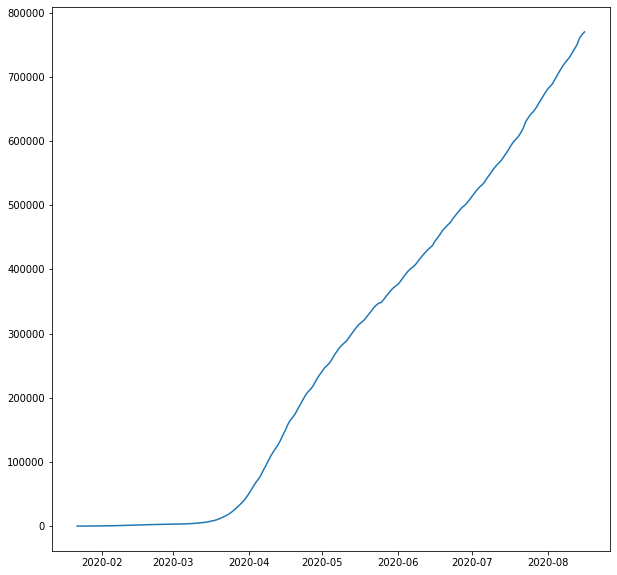

In [14]:
#plotting the total number of deaths
plt.figure(figsize=(10,10))
plt.plot(data)
plt.savefig('Cumulative Daily Deaths', bbox_inches = 'tight', transparent = False)

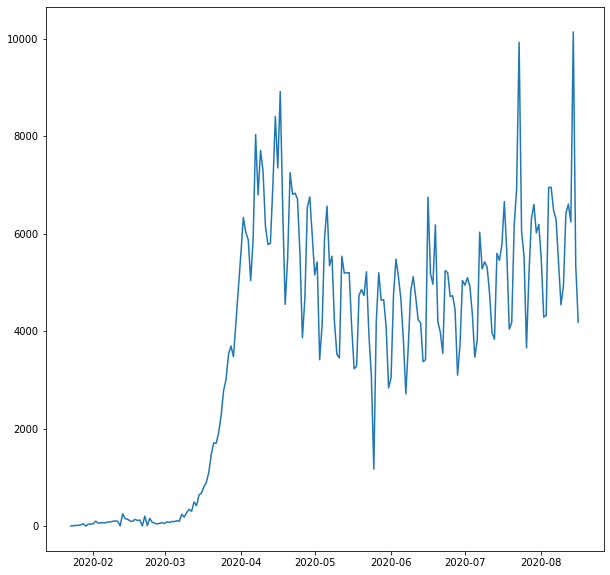

In [15]:
#plotting the daily increase in deaths
plt.figure(figsize = (10,10))
plt.plot(data.diff())
plt.savefig('Daily Deaths', bbox_inches = 'tight', transparent = False)

In [16]:
data=data.diff()
data

,y
ds,
2020-01-22,NaN
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
...,...
2020-08-12,6609.0
2020-08-13,6241.0
2020-08-14,10144.0


In [19]:
#To remove the NaN row
data = data.loc['2020-01-23':'2020-08-16'] 
data

,y
ds,
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
2020-01-27,26.0
2020-01-28,49.0
...,...
2020-08-12,6609.0
2020-08-13,6241.0
2020-08-14,10144.0


### Forecasting Using SARIMAX [Seasonal AutoRegressive  Integrated Moving Average with eXogenous Regressors Model]

SARIMAX was introduced as improvement over ARIMA, which struggles when data fluctuates seasonally. In the dataset, it can be seen that deaths spike on weekends. SARIMA has the ability to detect and predict these fluctuations in data.

In [20]:
#training set: all dates prior to 31-07-2020
start_date = '2020-07-31'

train = data.loc[data.index < pd.to_datetime(start_date)]
test = data.loc[data.index >= pd.to_datetime(start_date)]

In [21]:
train

,y
ds,
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
2020-01-27,26.0
2020-01-28,49.0
...,...
2020-07-26,3659.0
2020-07-27,5179.0
2020-07-28,6307.0


In [43]:
test.shape[0]

17

In [23]:
# order = (p, q, d) ; these are the hyperparameters of the model
model = SARIMAX(train, order = (2, 1, 3))
results = model.fit(disp = True)     #disp = True to display the progress of the fitting

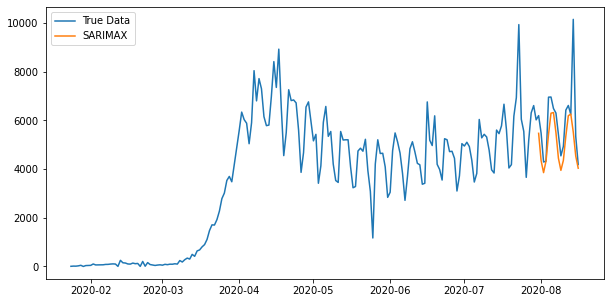

In [26]:
sarimax_prediction = results.predict( start = start_date, end = '2020-08-16', dynamic = False)
plt.figure(figsize = (10,5))
l1, = plt.plot(data, label = 'True Data')
l2, = plt.plot(sarimax_prediction, label = 'SARIMAX')
plt.legend(handles = [l1,l2])
plt.savefig('SARIMAX Prediction', bbox_inches = 'tight', transparent = False)

To compare the accuracy between different time series models, mean absolute error will be used.

In [28]:
print('SARIMAX MAE: ', mean_absolute_error(sarimax_prediction, test))

SARIMAX MAE:  864.2759523700947


Auto-ARIMA function used to find the best values of p,q,r  that will minimize the error.

In [30]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf', #used adftest to find optimal 'd'
                      max_p = 3, max_q = 3,
                      m=1,  #frequency of series
                      d = None, #let model determine d
                      seasonal = True,
                      start_P = 0,
                      trace = True,
                      error_action = 'ignore',
                      suppress_warnings = True,
                      stepwise = True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3096.315, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3116.765, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3118.178, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3117.717, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3114.979, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3083.984, Time=0.45 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3112.606, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3074.306, Time=0.52 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3101.050, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3020.742, Time=0.78 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3025.391, Time=0.60 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3017.535, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3010.760, Time=0.77 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3090.469, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept

### Forecasting using Facebook's Prophet Model

Prophet model doesn't require us to widely search for hyperparameters. The model acts as a black box and does all the computation on its own. It expects the dataframe to have 2 columns: dates and datapoints.

In [31]:
train['ds'] = train.index.values

In [32]:
train

,y,ds
ds,,
2020-01-24,8.0,2020-01-24
2020-01-25,16.0,2020-01-25
2020-01-26,14.0,2020-01-26
2020-01-27,26.0,2020-01-27
2020-01-28,49.0,2020-01-28
...,...,...
2020-07-26,3659.0,2020-07-26
2020-07-27,5179.0,2020-07-27
2020-07-28,6307.0,2020-07-28


In [34]:
fb_model = Prophet()
fb_model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
future = fb_model.make_future_dataframe(periods = data.shape[0] - train.shape[0])  #makes a data frame that stores the number of periods in which we need to forecast
prophet_prediction = fb_model.predict(future)

In [38]:
prophet_prediction      # y_hat = predicted values

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-24,-1092.456090,-2255.735395,903.055097,-1092.456090,-1092.456090,387.933216,387.933216,387.933216,387.933216,387.933216,387.933216,0.0,0.0,0.0,-704.522873
1,2020-01-25,-1023.765514,-2904.611783,288.635150,-1023.765514,-1023.765514,-166.782650,-166.782650,-166.782650,-166.782650,-166.782650,-166.782650,0.0,0.0,0.0,-1190.548164
2,2020-01-26,-955.074938,-3530.383274,-253.317711,-955.074938,-955.074938,-909.003600,-909.003600,-909.003600,-909.003600,-909.003600,-909.003600,0.0,0.0,0.0,-1864.078538
3,2020-01-27,-886.384362,-3273.724983,-0.179772,-886.384362,-886.384362,-728.438578,-728.438578,-728.438578,-728.438578,-728.438578,-728.438578,0.0,0.0,0.0,-1614.822940
4,2020-01-28,-817.693786,-1973.338264,1279.495778,-817.693786,-817.693786,452.841703,452.841703,452.841703,452.841703,452.841703,452.841703,0.0,0.0,0.0,-364.852083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2020-08-12,5298.803289,4112.215560,7370.554703,5257.248174,5339.098529,495.117035,495.117035,495.117035,495.117035,495.117035,495.117035,0.0,0.0,0.0,5793.920323
202,2020-08-13,5303.450691,4113.042457,7500.235638,5256.554177,5349.892684,468.332873,468.332873,468.332873,468.332873,468.332873,468.332873,0.0,0.0,0.0,5771.783564
203,2020-08-14,5308.098093,4100.952732,7364.519044,5256.167937,5360.035153,387.933216,387.933216,387.933216,387.933216,387.933216,387.933216,0.0,0.0,0.0,5696.031309
204,2020-08-15,5312.745495,3479.337475,6708.865043,5255.190201,5369.930200,-166.782650,-166.782650,-166.782650,-166.782650,-166.782650,-166.782650,0.0,0.0,0.0,5145.962845


In [39]:
prophet_prediction = prophet_prediction.set_index('ds')
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index >= start_date]

In [40]:
prophet_future

ds
2020-07-31    5630.967679
2020-08-01    5080.899215
2020-08-02    4343.325667
2020-08-03    4528.538092
2020-08-04    5714.465775
2020-08-05    5761.388508
2020-08-06    5739.251749
2020-08-07    5663.499494
2020-08-08    5113.431030
2020-08-09    4375.857482
2020-08-10    4561.069907
2020-08-11    5746.997590
2020-08-12    5793.920323
2020-08-13    5771.783564
2020-08-14    5696.031309
2020-08-15    5145.962845
2020-08-16    4408.389298
Name: yhat, dtype: float64

In [41]:
print('Prophet MAE:', mean_absolute_error(prophet_future, test))

Prophet MAE: 745.9839168156628


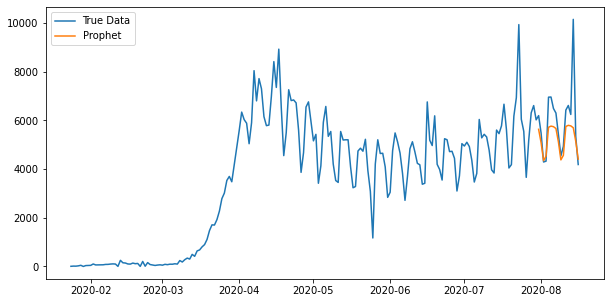

In [42]:
plt.figure(figsize = (10,5))
l1, = plt.plot(data, label = 'True Data')
l2, = plt.plot(prophet_future, label = 'Prophet')
plt.legend(handles = [l1,l2])
plt.savefig('Prophet Prediction', bbox_inches = 'tight', transparent = False)

### Preparing the data for XGBoost and  Feed-Forward Neural Network Model

XGBoost and NN models are supervised ML models, hence, they assume that each data point is independent of the rest of the data points in the dataset. We've to,thus, capture the chronological order of the dataset without explicitly using the date values.

In [44]:
def featurize(t):     #extract features from the date
  X = pd.DataFrame()

  X['day'] = t.index.day
  X['month'] = t.index.month
  X['quarter'] = t.index.quarter
  X['dayofweek'] = t.index.dayofweek
  X['dayofyear'] = t.index.dayofyear
  X['weekofyear'] = t.index.weekofyear

  y = t.y

  return X,y

In [46]:
featurize(data)[0]

,day,month,quarter,dayofweek,dayofyear,weekofyear
0,24,1,1,4,24,4
1,25,1,1,5,25,4
2,26,1,1,6,26,4
3,27,1,1,0,27,5
4,28,1,1,1,28,5
...,...,...,...,...,...,...
201,12,8,3,2,225,33
202,13,8,3,3,226,33
203,14,8,3,4,227,33
204,15,8,3,5,228,33


### Creating Training and Test Datasets by Splitting the Dataset and Performing Data Normalization

We can't use scikit's train_test split [where a random portion of the dataset is taken as the test set and the remaining is the training set] or k-fold cross validation split in time series data because when we train the model on the training set, the purpose is to predict the target values in the future, which correspond to date values that are outside the date values in the training set.

In [49]:
X_train,y_train = featurize(data.loc[(data.index < pd.to_datetime(start_date))])
X_test, y_test = featurize(data.loc[(data.index >= pd.to_datetime(start_date))])

In [50]:
X_train

,day,month,quarter,dayofweek,dayofyear,weekofyear
0,24,1,1,4,24,4
1,25,1,1,5,25,4
2,26,1,1,6,26,4
3,27,1,1,0,27,5
4,28,1,1,1,28,5
...,...,...,...,...,...,...
184,26,7,3,6,208,30
185,27,7,3,0,209,31
186,28,7,3,1,210,31
187,29,7,3,2,211,31


In [51]:
y_train

ds
2020-01-24       8.0
2020-01-25      16.0
2020-01-26      14.0
2020-01-27      26.0
2020-01-28      49.0
               ...  
2020-07-26    3659.0
2020-07-27    5179.0
2020-07-28    6307.0
2020-07-29    6605.0
2020-07-30    6019.0
Name: y, Length: 189, dtype: float64

In [52]:
#standard scaler to normalize data since there is a large difference in values between dayofyear and dayofweek
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [54]:
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

###XGBoost Model

In [118]:
XGBoost_model = XGBRegressor(n_estimators=1020, objective='reg:squarederror')

In [119]:
XGBoost_model.fit(scaled_train, y_train, eval_set=[ (scaled_train, y_train),(scaled_test, y_test)], verbose = True)

[0]	validation_0-rmse:3936.64	validation_1-rmse:5597.12
[1]	validation_0-rmse:3572.62	validation_1-rmse:5150.74
[2]	validation_0-rmse:3243.3	validation_1-rmse:4787.85
[3]	validation_0-rmse:2947.65	validation_1-rmse:4457.03
[4]	validation_0-rmse:2681.46	validation_1-rmse:4130.2
[5]	validation_0-rmse:2445.5	validation_1-rmse:3869.12
[6]	validation_0-rmse:2229.39	validation_1-rmse:3550.36
[7]	validation_0-rmse:2035.76	validation_1-rmse:3264.83
[8]	validation_0-rmse:1860.77	validation_1-rmse:3054
[9]	validation_0-rmse:1704.56	validation_1-rmse:2832.47
[10]	validation_0-rmse:1563.29	validation_1-rmse:2635.1
[11]	validation_0-rmse:1438.46	validation_1-rmse:2500.8
[12]	validation_0-rmse:1326.4	validation_1-rmse:2365.82
[13]	validation_0-rmse:1224.9	validation_1-rmse:2199.78
[14]	validation_0-rmse:1135.52	validation_1-rmse:2037.85
[15]	validation_0-rmse:1054.15	validation_1-rmse:1937.49
[16]	validation_0-rmse:983.341	validation_1-rmse:1817.06
[17]	validation_0-rmse:919.637	validation_1-rmse:17

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1020,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [117]:
XGBoost_prediction = XGBoost_model.predict(scaled_test)

In [113]:
XGBoost_prediction

array([2806.766 , 2676.6357, 2079.761 , 2217.2097, 2806.766 , 2806.766 ,
       2806.766 , 2806.766 , 2676.6357, 2079.761 , 2217.2097, 2806.766 ,
       2806.766 , 2806.766 , 2806.766 , 2676.6357, 2079.761 ],
      dtype=float32)

In [114]:
print('XGBOOST MAE: ', mean_absolute_error(XGBoost_prediction, y_test))

XGBOOST MAE:  3342.852668313419


### Neural Network Model

In [86]:
nn_model = Sequential()
nn_model.add(Dense(20, input_shape = (6,))) #params: 20*6 + 20
nn_model.add(Dense(10))   #params: 10*20 + 10
nn_model.add(Dense(1))  
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                140       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [87]:
nn_model.compile(loss='mean_absolute_error', optimizer = Adam(lr = 0.001))

In [88]:
nn_model.fit(scaled_train, y_train, validation_data=(scaled_test, y_test), epochs = 220, verbose = 1)

Epoch 1/220
6/6 [==============================] - 15s 108ms/step - loss: 3529.5352 - val_loss: 5932.0938
Epoch 2/220
6/6 [==============================] - 0s 6ms/step - loss: 3650.0564 - val_loss: 5931.8896
Epoch 3/220
6/6 [==============================] - 0s 5ms/step - loss: 3693.2593 - val_loss: 5931.7407
Epoch 4/220
6/6 [==============================] - 0s 6ms/step - loss: 3685.1909 - val_loss: 5931.6606
Epoch 5/220
6/6 [==============================] - 0s 6ms/step - loss: 3382.2709 - val_loss: 5931.6333
Epoch 6/220
6/6 [==============================] - 0s 8ms/step - loss: 3448.9902 - val_loss: 5931.5117
Epoch 7/220
6/6 [==============================] - 0s 9ms/step - loss: 3528.3099 - val_loss: 5931.3281
Epoch 8/220
6/6 [==============================] - 0s 7ms/step - loss: 3264.5057 - val_loss: 5931.3369
Epoch 9/220
6/6 [==============================] - 0s 7ms/step - loss: 3492.0084 - val_loss: 5931.2061
Epoch 10/220
6/6 [==============================] - 0s 7ms/step - loss

In [89]:
nn_prediction = nn_model.predict(scaled_test)

In [93]:
print('Neural Network MAE = ', mean_absolute_error(nn_prediction, y_test))

Neural Network MAE =  1019.1511661305148


<Figure size 1440x1440 with 0 Axes>

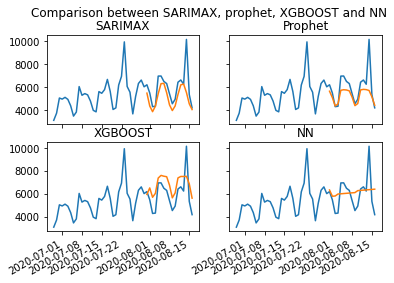

In [100]:

XGBOOST_df = pd.DataFrame({'y': XGBoost_prediction.tolist()})
XGBOOST_df.index = y_test.index

NN_df = pd.DataFrame(nn_prediction)
NN_df.index = y_test.index
plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 2)
fig.suptitle('Comparison between SARIMAX, prophet, XGBOOST and NN')
axs[0, 0].plot(data.tail(50))
axs[0, 0].plot(sarimax_prediction.tail(50))
axs[0, 0].set_title("SARIMAX")
axs[0, 1].plot(data.tail(50))
axs[0, 1].plot(prophet_future.tail(50))
axs[0, 1].set_title("Prophet")
axs[1, 0].plot(data.tail(50))
axs[1, 0].plot(XGBOOST_df.tail(50))
axs[1, 0].set_title("XGBOOST")
axs[1, 1].plot(data.tail(50))
axs[1, 1].plot(NN_df.tail(50))
axs[1, 1].set_title("NN")

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',
            bbox_inches='tight', transparent=False)